##Importing Libraries

In [40]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
#Load Dataset
df=pd.read_csv('imdb_dataset.csv')
print(df.shape)
df.head()


(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


##Visualization
To visualize the work and choose the proper approach to pre-process data and visualize the text data.

So What is the most common words? Use different approach to visualize the most common words. From this we can find out if any inappropriate words which could be removed.



In [7]:
from collections import Counter
Counter(" ".join(df["review"]).lower().split()).most_common(100)

[('the', 638861),
 ('a', 316615),
 ('and', 313637),
 ('of', 286661),
 ('to', 264573),
 ('is', 204876),
 ('in', 179807),
 ('i', 141587),
 ('this', 138483),
 ('that', 130140),
 ('it', 129614),
 ('/><br', 100974),
 ('was', 93258),
 ('as', 88242),
 ('with', 84590),
 ('for', 84510),
 ('but', 77864),
 ('on', 62890),
 ('movie', 61492),
 ('are', 57009),
 ('his', 56870),
 ('not', 56765),
 ('you', 55600),
 ('film', 55086),
 ('have', 54423),
 ('he', 51062),
 ('be', 50901),
 ('at', 45259),
 ('one', 44983),
 ('by', 43359),
 ('an', 42330),
 ('they', 40860),
 ('from', 39322),
 ('all', 38570),
 ('who', 38326),
 ('like', 37281),
 ('so', 35972),
 ('just', 34259),
 ('or', 33300),
 ('has', 32610),
 ('about', 32398),
 ('her', 31244),
 ("it's", 31212),
 ('if', 30794),
 ('some', 30165),
 ('out', 28980),
 ('what', 28008),
 ('very', 26908),
 ('when', 26904),
 ('there', 26079),
 ('more', 25869),
 ('would', 23807),
 ('even', 23681),
 ('my', 23473),
 ('good', 23467),
 ('she', 23418),
 ('their', 22604),
 ('only', 

In [14]:
#Label Encoding
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [15]:
df.sentiment.value_counts()

1    25000
0    25000
Name: sentiment, dtype: int64

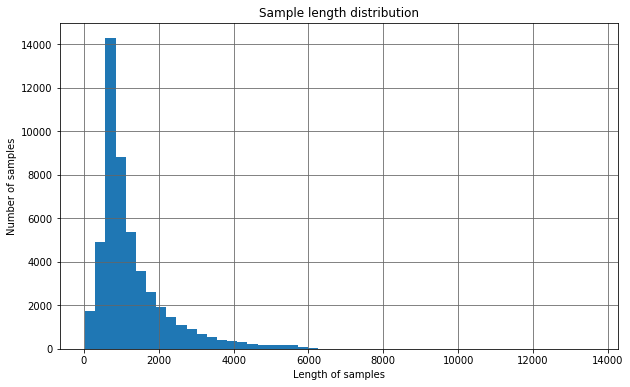

In [49]:
# Now, let's see the average number of words per sample
plt.figure(figsize=(10, 6))
plt.hist([len(sample) for sample in list(df['review'])], 50)
plt.xlabel('Length of samples')
plt.ylabel('Number of samples')
plt.title('Sample length distribution')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.show()

In [0]:
df['review'] = df['review'].str.replace('<br />','')
df['review'] = df['review'].str.lower()

In [19]:
print('The maximum length of a sentence is: ',np.max(df['review'].str.split().apply(len).value_counts()))
print('The average lenth of a sentence is: ', np.average(df['review'].str.split().apply(len).value_counts()))

The maximum length of a sentence is:  401
The average lenth of a sentence is:  48.732943469785575


##Vectorization
Basically Vectorization is the general process of turning a collection of text documents into numerical feature vectors.

CountVectorizer provided by the scikit-learn library to vectorize sentences. It takes the words of each sentence and creates a vocabulary of all the unique words in the sentences. This vocabulary can then be used to create a feature vector of the count of the words:

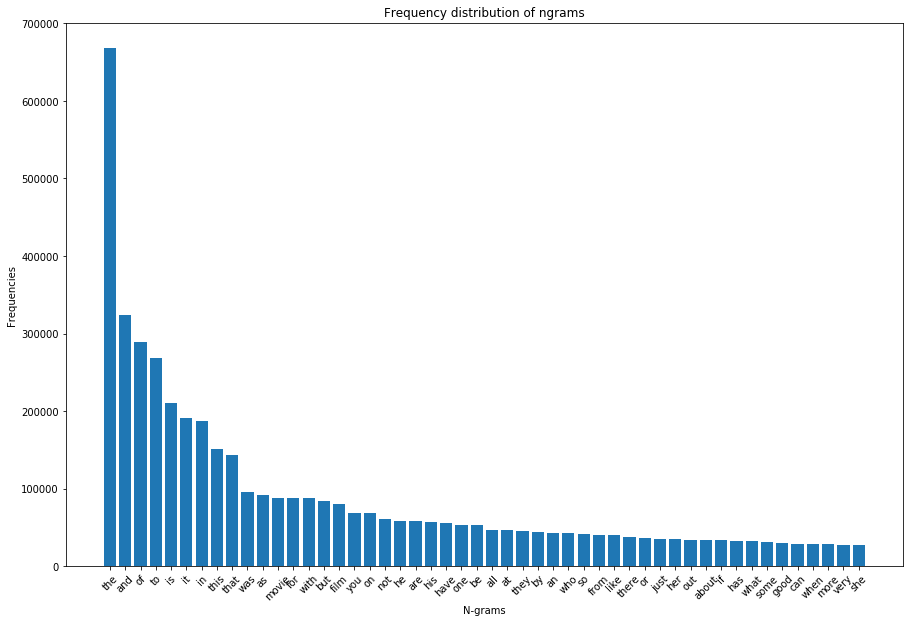

In [51]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vect_texts = vectorizer.fit_transform(list(df['review']))
# ['word1', 'word2', 'word3', 'word4']
all_ngrams = vectorizer.get_feature_names()
num_ngrams = min(50, len(all_ngrams))
all_counts = vect_texts.sum(axis=0).tolist()[0]

all_ngrams, all_counts = zip(*[(n, c) for c, n in sorted(zip(all_counts, all_ngrams), reverse=True)])
ngrams = all_ngrams[:num_ngrams]
counts = all_counts[:num_ngrams]

idx = np.arange(num_ngrams)

# Let's now plot a frequency distribution plot of the most seen words in the corpus.
plt.figure(figsize=(15, 10))
plt.bar(idx, counts, width=0.8)
plt.xlabel('N-grams')
plt.ylabel('Frequencies')
plt.title('Frequency distribution of ngrams')
plt.xticks(idx, ngrams, rotation=45)
plt.show()


##TF IDF Vectorizer -> Term frequency_Inverse document frequency
The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.

Let's now prepare the data to feed into the model. For the data preparation step we will get bigrams and unigrams from the data and encode it using tf-idf. And will select the top 20000 features from the vector of tokens. Discard features that occurs less than two times, and will f_classif to get feature importance.

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
NGRAM_RANGE = (1, 2)
TOP_K = 20000
TOKEN_MODE = 'word'
MIN_DOC_FREQ = 2

def ngram_vectorize(texts, labels):
    kwargs = {
        'ngram_range' : NGRAM_RANGE,
        'dtype' : 'int32',
        'strip_accents' : 'unicode',
        'decode_error' : 'replace',
        'analyzer' : TOKEN_MODE,
        'min_df' : MIN_DOC_FREQ,
    }
    # Learn Vocab from train texts and vectorize train and val sets
    tfidf_vectorizer = TfidfVectorizer(**kwargs)
    transformed_texts = tfidf_vectorizer.fit_transform(texts)
    
    # Select best k features, with feature importance measured by f_classif
    # Set k as 20000 or (if number of ngrams is less) number of ngrams   
    selector = SelectKBest(f_classif, k=min(TOP_K, transformed_texts.shape[1]))
    selector.fit(transformed_texts, labels)
    transformed_texts = selector.transform(transformed_texts).astype('float32')
    return transformed_texts
# Vectorize the data
vect_data = ngram_vectorize(df['review'], df['sentiment'])

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:1817: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


In [26]:
vect_data.shape

(50000, 20000)

In [29]:
from sklearn.model_selection import train_test_split
X = vect_data.toarray()
y = (np.array(df['sentiment']))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
print("Train dataset shape: {0}, \nTest dataset shape: {1}".format(X_train.shape, X_test.shape))

Train dataset shape: (40000, 20000), 
Test dataset shape: (10000, 20000)


##Build the Model

In [41]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=200, epochs=5)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 40000 samples
Epoch 1/5
40000/40000 [==============================] - 36s 891us/sample - loss: 0.2532 - acc: 0.9040
Epoch 2/5
40000/40000 [==============================] - 36s 893us/sample - loss: 0.1066 - acc: 0.9617
Epoch 3/5
40000/40000 [==============================] - 36s 889us/sample - loss: 0.0533 - acc: 0.9823
Epoch 4/5
40000/40000 [==============================] - 36s 891us/sample - loss: 0.0199 - acc: 0.9940
Epoch 5/5
40000/40000 [==============================] - 36s 893us/sample - loss: 0.0059 - acc: 0.9985


In [42]:
y_pred= model.predict_classes(X_test)
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_pred, y_test)
print("Test Accuracy :",100*acc)

Test Accuracy : 91.9
